### Import

In [1]:
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
import kagglehub

In [2]:
warnings.filterwarnings('ignore')

## `Finger Digits 0–5 Dataset Overview`

The **Finger Digits 0–5** dataset is a hand gesture image dataset designed for real-time digit classification tasks, where the objective is to recognize the number of fingers (from 0 to 5) shown by a hand in an image. 

### Dataset Summary  
- **Samples:** ~12,000 images  
- **Image Size:** 128 × 128 pixels  
- **Channels:** 1 (grayscale, thresholded)  
- **Classes:** 6 (digits 0 to 5)  
- **Format:** Preprocessed (thresholded) images  
- **Balance:** ~2000 images per class  

### Dataset Link  
Link to the dataset on Kaggle

[https://www.kaggle.com/datasets/roshea6/finger-digits-05](https://www.kaggle.com/datasets/roshea6/finger-digits-05)

In [6]:
os.environ["KAGGLEHUB_CACHE"] = "data"

path = kagglehub.dataset_download("roshea6/finger-digits-05")

## Constants

In [7]:
NUM_CLASSES = 6 # The number of output classes, representing digits from 0 to 5 (inclusive)
IMG_SIZE = 64   # The width and height to which all input images are resized (64x64 pixels)
IMAGES_DIR = os.path.join(path, "training_images (copy)")  # Directory where images are stored

#### Displaying the Image

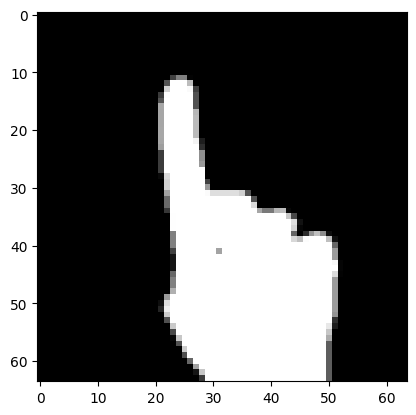

In [8]:
img_path = os.path.join(IMAGES_DIR, "0_1.png")
img = cv2.imread(img_path,0)
img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
plt.imshow(img,cmap='gray')

#### Checking Image Dimensions

In [9]:
img.shape

(64, 64)

#### Checking Maximum Pixel Value

In [10]:
img.max()

255

## Loading the Dataset

The `load_images_and_labels` function loads images from a specified directory, extracts their labels based on the filenames

In [11]:
def load_images_and_labels(image_dir, img_size=64):
    """
    Loads images from a specified directory, extracts their labels

    Args:
    - image_dir (str): The directory containing the image files.
    - img_size (int): The size to which images will be resized (default is 64).
    - channels (int): The number of channels for the images (1 for grayscale, 3 for RGB).

    Returns:
    - X (numpy array): Array of preprocessed images.
    - y (numpy array): Array of labels corresponding to the images.
    """

    X = []  # List to store images
    y = []  # List to store labels

    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            label = int(filename.split("_")[1].split(".")[0])

            img_path = os.path.join(image_dir, filename)
            img = cv2.imread(img_path, 0)  # Load image in grayscale
            img = cv2.resize(img, (img_size, img_size))

            X.append(img)
            y.append(label)
    
    return X, y

#### Load the images using the `load_images_and_labels`

In [12]:
X, y = load_images_and_labels(IMAGES_DIR,IMG_SIZE)

#### Reshapes and normalizes the images

In [13]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # (samples, 64, 64, 1)
X = X / 255.0  
y = np.array(y)

In [14]:
print(f"Total number of images: {len(y)}")
print(f"Shape X: {X.shape}")
print(f"Unique labels (classes): {np.unique(y)}")

Total number of images: 12006
Shape X: (12006, 64, 64, 1)
Unique labels (classes): [0 1 2 3 4 5]


### Splitting the Dataset

In [15]:
y_cat = to_categorical(y, NUM_CLASSES)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat,random_state=0)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (9004, 64, 64, 1), (9004, 6)
Test set: (3002, 64, 64, 1), (3002, 6)


### Data Augmentation
Data augmentation to artificially increase the size of the training dataset by applying random transformations to the original images. This helps to prevent overfitting and allows the model to generalize better

In [16]:
datagen = ImageDataGenerator(
    rotation_range=20,        # Random rotations (up to 20 degrees)
    width_shift_range=0.2,    # Width shift (up to 20%)
    height_shift_range=0.35,   # Height shift (up to 35%)
    shear_range=0.15,         # Shear/distortion
    zoom_range=0.2,           # Zooming
    horizontal_flip=True,     # Horizontal flip (hands should be represented in both orientations in the dataset?)
    fill_mode='nearest'       # Fill new pixels after transformations
)

### Training Data Generator

In [17]:
batch_size = 32

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size,)
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size)

### Viewing the generated image with train_generator

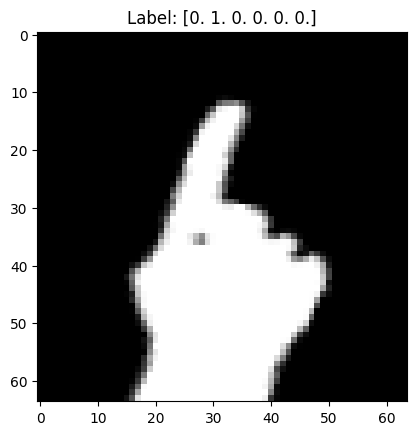

In [18]:
images, labels  = next(train_generator)

plt.imshow(images[0], cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

## CNN Model Architecture

Define a Convolutional Neural Network (CNN) 
The input images are resized to **64x64** and have a single channel. The model includes:

- Three convolutional blocks with increasing filter sizes (32 -> 64 -> 128), each followed by a max pooling layer.
- A fully connected dense layer with 128 neurons and a dropout layer to reduce overfitting.
- An output layer with **6 units** and softmax activation to predict the digit class (0–5).

The model is compiled using the **Adam optimizer** and `categorical_crossentropy` loss function for multi-class classification.

In [19]:
input_shape = (IMG_SIZE, IMG_SIZE, 1)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape), 
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,398 (2.61 MB)

 Trainable params: 683,398 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

### Model Architecture Breakdown

1. **Conv2D (conv2d)**: First convolutional layer with 32 filters of size 3x3, reducing the image size from (64x64) to (62x62)
2. **MaxPooling2D (max_pooling2d)**: Max pooling layer that reduces the spatial dimensions of the image to (31x31)
3. **Conv2D (conv2d_1)**: Second convolutional layer with 64 filters of size 3x3, reducing the size to (29x29)
4. **MaxPooling2D (max_pooling2d_1)**: Max pooling layer that further reduces the dimensions to (14x14)
5. **Conv2D (conv2d_2)**: Third convolutional layer with 128 filters of size 3x3, reducing the size to (12x12)
6. **MaxPooling2D (max_pooling2d_2")**: Max pooling layer that reduces the dimensions to (6x6)
7. **Flatten (flatten)**: Flattens the spatial dimensions into a one-dimensional vector of size 4608
8. **Dense (dense)**: Fully connected layer with 128 neurons for further processing
9. **Dropout (dropout)**: Dropout layer applied to reduce overfitting by randomly setting a fraction of input units to 0 during training
10. **Dense (dense_1)**: Final output layer with 6 neurons, corresponding to the 6 output classes (digits 0-5)
---

## Training the Model

The CNN model is trained using the augmented training data generated with `ImageDataGenerator`. Training parameters:

- **Epochs**: 15
- **Batch size**: 32

In [20]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator
)

Epoch 1/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 43s 143ms/step - accuracy: 0.4564 - loss: 1.2727 - val_accuracy: 0.8584 - val_loss: 0.3760
Epoch 2/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.8386 - loss: 0.4082 - val_accuracy: 0.8881 - val_loss: 0.2806
Epoch 3/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.8809 - loss: 0.3116 - val_accuracy: 0.9567 - val_loss: 0.1206
Epoch 4/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 147ms/step - accuracy: 0.9216 - loss: 0.2203 - val_accuracy: 0.9547 - val_loss: 0.1270
Epoch 5/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - accuracy: 0.9338 - loss: 0.1816 - val_accuracy: 0.9597 - val_loss: 0.1182
Epoch 6/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - accuracy: 0.9459 - loss: 0.1666 - val_accuracy: 0.9720 - val_loss: 0.0817
Epoch 7/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.9473 - loss: 0.1487 - val_accuracy: 0.9684 - val_loss: 0.0822
Epoch 8/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.9567 - loss: 0

### Visualize how the accuracy and loss of the model change over epochs for both the training and validation sets.

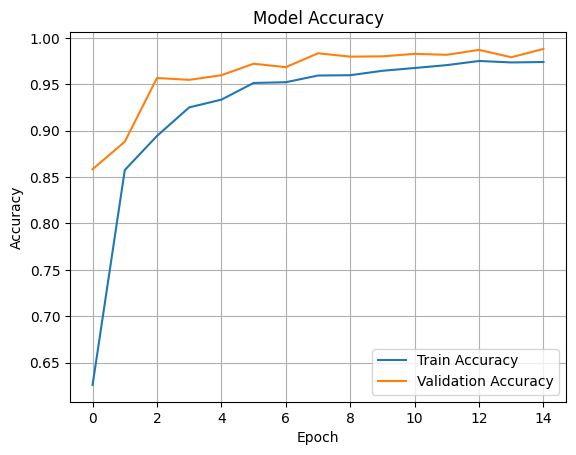

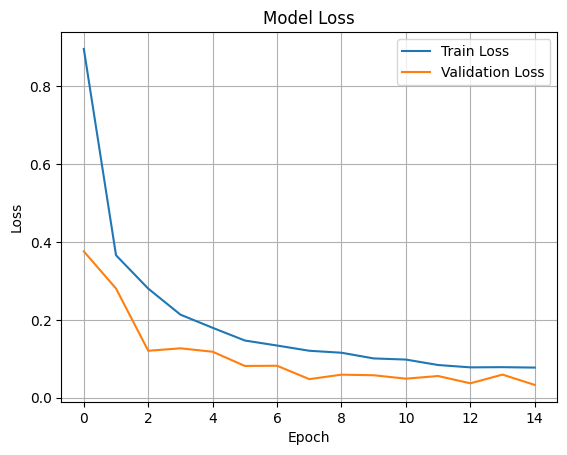

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Saving model

In [ ]:
model_save_path = "../src/models/finger_count_model.h5"
model.save(model_save_path)